# Initial Imports

In [132]:
import pandas as pd
import numpy as np
from nltk import ngrams
from wordcloud import WordCloud
import spacy
from spacy import displacy
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from wordcloud import ImageColorGenerator
from collections import defaultdict
import random
import re
from gtts import gTTS 
import os
pd.options.plotting.backend = 'hvplot'

# Custom .py files
from get_lyric_data import get_lyrics
from get_chart_data import get_chart_genre
from text_processor import process_text
from get_lyrics_sentiment import lyrics_sentiment

# Lyric Data

### Search for top songs in GENRE

In [3]:
""" SHAZAM CORE API REQUEST """
""" WORLD CHART BY GENRE ENDPOINT """

# Use 'World Chart By Genre' endpoint to retrieve chart for a single genre

# GENRE CODES
# POP,HIP_HOP_RAP,DANCE,ELECTRONIC,SOUL_RNB,ALTERNATIVE,ROCK,LATIN,FILM_TV,COUNTRY,
# AFRO_BEATS,WORLDWIDE,REGGAE_DANCE_HALL,HOUSE,K_POP,FRENCH_POP,SINGER_SONGWRITER,REG_MEXICO

genre = 'COUNTRY'
limit_songs = 50

querystring = {"genre_code": genre, "limit" :limit_songs}
chart_response = get_chart_genre(querystring)

In [4]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)


The number of songs retrieved is : 50


,Track Name,Artists
TrackIDs,,
445958237,Dear Rodeo,Cody Johnson
54640449,Jingle Bell Rock,Bobby Helms
311266220,Break My Heart Sweetly,John Moreland
568180108,Fancy Like,Walker Hayes
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus


In [5]:
# Take a look at the data

from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

# Plot artists frequency in top chart
genre_plot = artists_df.plot.bar(rot=45, width = 1000, height = 600, color = 'yellow', title = f'Top Artists on {genre} Chart')
genre_plot

:Bars   [Artists]   (No. Songs in Top Chart)

In [6]:
# Top 5 artists
artists_df.iloc[:5]

,No. Songs in Top Chart
Artists,
Taylor Swift,3
Chris Stapleton,3
Cody Johnson,2
Walker Hayes,2
Shania Twain,2


### Search lyrics by TRACK

In [7]:
""" SHAZAM CORE API REQUEST """
""" TRACK DETAILS ENDPOINT """

# Retrieve Lyrics for all TrackIDs

track_ids  # the list created in "Search for top songs in Genre" section is required

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  # Note: tracks with a type != "LYRICS" don't contain lyrics
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

### Generate Lyrics DataFrame

In [8]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
445958237,Dear Rodeo,Cody Johnson,Dear rodeo I'd be lying if I tried to tell you...
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin..."
311266220,Break My Heart Sweetly,John Moreland,I swore the days were over Of courtin empty d...
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ..."


In [9]:
# Remove songs without lyrics

lyrics_df.drop(lyrics_df.loc[lyrics_df['Lyrics'] == ''].index.tolist(), inplace=True)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
445958237,Dear Rodeo,Cody Johnson,Dear rodeo I'd be lying if I tried to tell you...
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin..."
311266220,Break My Heart Sweetly,John Moreland,I swore the days were over Of courtin empty d...
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ..."


In [10]:
# Find frequency of specific word
lyrics_df['Lyrics'].str.count('oh').sum()

111

### Export lyrics to a .csv file

In [11]:
# Export lyrics to .csv file
lyrics_df.to_csv('lyrics_df.csv', index_label='TrackID')

# Sentiment Analysis

In [12]:
# Use custom function lyrics_sentiment to analyze text with VADER

scores = lyrics_sentiment(lyrics_df)
sentiments_df = pd.concat([lyrics_df, scores], axis=1, join='inner')
sentiments_df.head()

,Track Name,Artists,Lyrics,compound,positive,negative,neutral
445958237,Dear Rodeo,Cody Johnson,Dear rodeo I'd be lying if I tried to tell you...,-0.9382,0.134,0.190,0.676
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin...",0.8442,0.049,0.000,0.951
311266220,Break My Heart Sweetly,John Moreland,I swore the days were over Of courtin empty d...,0.9710,0.173,0.084,0.743
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...,0.9986,0.238,0.020,0.742
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ...",0.9643,0.110,0.020,0.871


In [13]:
# Compute overall score for each track based on compound score

def overall_sentiment(score):

    """ Calculates the overall sentiment based on the compound score """

    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

sentiments_df['overall'] = sentiments_df['compound'].apply(lambda score: overall_sentiment(score))
sentiments_df.sample(5)

,Track Name,Artists,Lyrics,compound,positive,negative,neutral,overall
574511388,Ride the Lightning (717 Tapes),Warren Zeiders,Mama always said I was born on the wild side O...,0.5106,0.082,0.077,0.841,1
10546505,Man! I Feel Like A Woman!,Shania Twain,Let's go girls Come on! I'm goin' out tonight...,0.9934,0.209,0.077,0.714,1
265721100,Sleeping On The Blacktop,Colter Wall,Sunshine beating on the good times Moonlight r...,-0.6769,0.051,0.074,0.875,-1
456773549,I Hope,Gabby Barrett,"I, I hope she makes you smile The way it made ...",0.9993,0.316,0.047,0.637,1
549087581,Wilder Days,Morgan Wade,Hand in my hair and you said I looked pretty Y...,0.9878,0.166,0.086,0.748,1


In [194]:
# Plot overall sentiment scores for genre

positives = sentiments_df['overall'].loc[sentiments_df['overall'] == 1 ].count()
negatives = sentiments_df['overall'].loc[sentiments_df['overall'] == -1 ].count()
index_names = ['Positive', 'Negative']

overall = pd.DataFrame([positives,negatives], columns = ['Count'])
overall.index = index_names

country_sentiment_pie = px.pie(
    overall, 
    values = 'Count', 
    names=index_names,
    height=500, 
    width=1000,
    hole = 0.4, 
    color_discrete_sequence=["yellow", "orange"],  
    title=f'Overall Sentiment for {genre} Song Lyrics'
    )


print(f'The total number of positive songs is {positives}')
print(f'The total number of negative songs is {negatives}')      
country_sentiment_pie

The total number of positive songs is 33
The total number of negative songs is 14


In [192]:
# Save CSV of sentiment scores
overall.to_csv(f'../all_genres/{genre}_sentiments.csv', index_label='Sentiment')

# Natural Language Processing

### Tokenizer

In [15]:
# Create a list of stopwords
sw_custom = {'wouldnt','got', 'get','would','ohoh','ooh', 'oh','youll','wan','tell', 'see','wouldn','didnt', 'there', 'theres','said', 'youve', 'wa', 'dont', 'cant', 'oh','ive', 'ill', 'na', 'youre', 'gon', 'im', 'go', 'id', 'say', 'aint', 'oh', 'jingle', 'bell', 'santa', 'claus'}

# Run the text_processor function for lyrics dataframe
lyrics_tokenized = [process_text(text, sw_custom) for text in lyrics_df['Lyrics']]

# Create a new tokens column for dataframe
lyrics_df['Tokens'] = lyrics_tokenized
lyrics_df.head(3)

,Track Name,Artists,Lyrics,Tokens
445958237,Dear Rodeo,Cody Johnson,Dear rodeo I'd be lying if I tried to tell you...,"[dear, rodeo, lying, tried, think, mile, wild,..."
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin...","[rock, swing, ring, snowing, blowing, bushel, ..."
311266220,Break My Heart Sweetly,John Moreland,I swore the days were over Of courtin empty d...,"[swore, day, courtin, empty, dream, worshipped..."


### N-Grams and Frequency Analyzer

In [16]:
# Function bigrams_counter retrieves bigrams in a list of texts

def bigrams_counter(texts, n_results, sw_custom): 
    # Combine all articles in corpus into one large string
    big_string = ' '.join(texts)
    processed = process_text(big_string, sw_custom)
    bigrams = ngrams(processed, n=2)
    top = dict(Counter(bigrams).most_common(n_results))
    return pd.DataFrame(list(top.items()), columns=['Bigram', 'Count']).set_index('Bigram')

In [17]:
# Generate the N-grams where N=2
bigrams_counter(lyrics_df['Lyrics'], 10, sw_custom)

,Count
Bigram,
"(good, time)",24
"(still, one)",20
"(trouble, trouble)",19
"(pretty, woman)",17
"(thinking, bout)",12
"(probably, leave)",12
"(hey, darlin)",12
"(tryna, catch)",12
"(catch, good)",12


In [18]:
# Frequency Analysis

# Function token_count generates the top N words for given text
def token_count(tokens, n_results):
    """ Returns the top N tokens """
    """ Requires a dataframe series as input"""
    big_string = ' '.join(map(str,tokens))
    processed = process_text(big_string, sw_custom)
    topN = dict(Counter(processed).most_common(n_results))
    return pd.DataFrame(list(topN.items()), columns=['Word', 'Count']).set_index('Word')

# Plot most common tokens
top_words = token_count(lyrics_df['Tokens'],50)
top_words.plot.bar(rot=90, width=1000, color='yellow', title =f'Top Words for {genre}')


:Bars   [Word]   (Count)

In [19]:
# Export genre top_words to csv
top_words.to_csv(f'../all_genres/{genre}_top_words.csv')

### Word Cloud

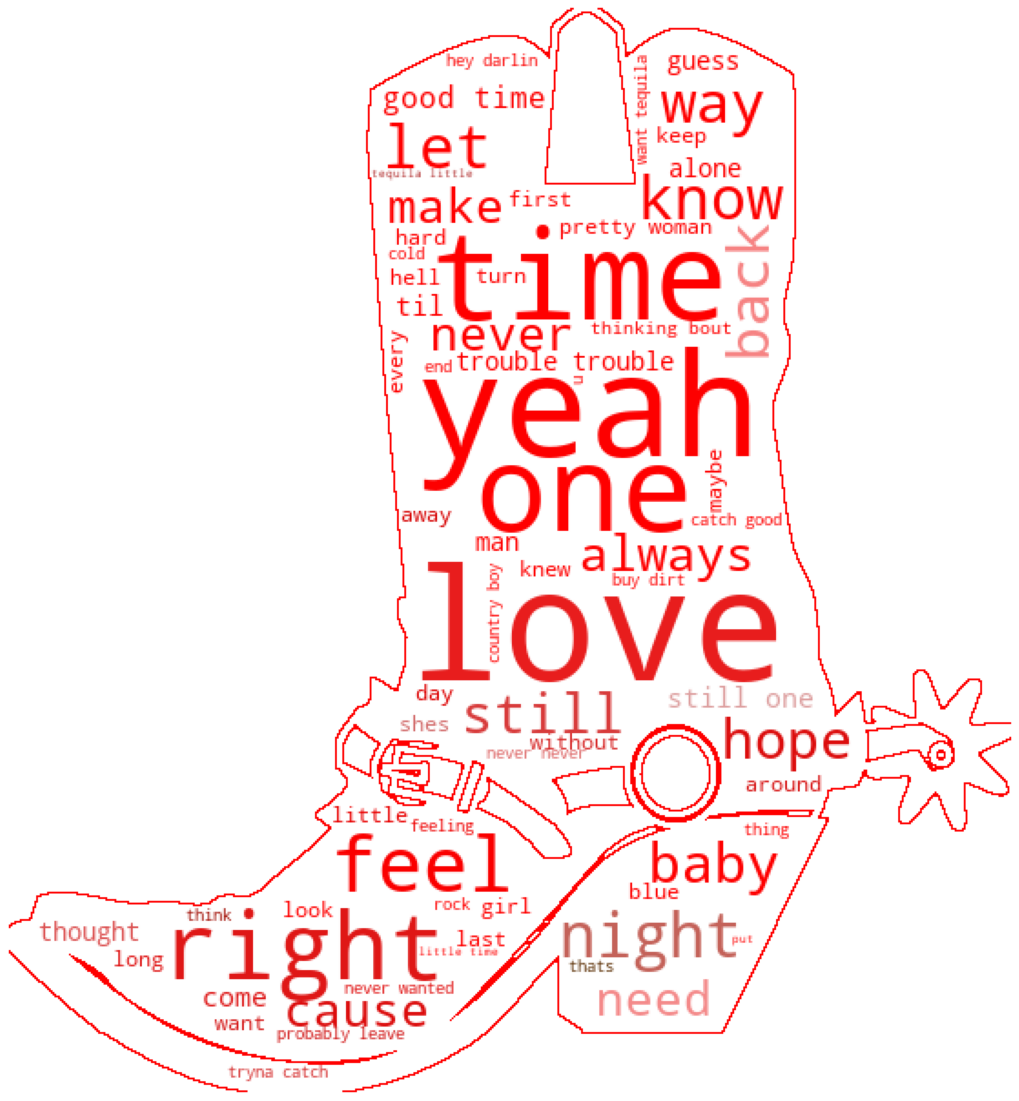

In [20]:
# Generate a word cloud image

# Text for word cloud

big_string = ' '.join(lyrics_df['Lyrics'])
lyrics_text = process_text(big_string, sw_custom)

# Add mask
mask = np.array(Image.open("images/cowboy-boot.png"))

# Create Word Cloud
wc_boot = WordCloud(contour_width=1, contour_color='red', width=2000, height=2000, background_color="white", max_words=70, mask=mask).generate(' '.join(lyrics_text))

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wc_boot.recolor(color_func=image_colors), interpolation="bilinear")

plt.axis("off")
plt.imshow(wc_boot)

# Save image as png
wc_boot.to_file("images/country.png")

# Name Entity Recognition

In [21]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [22]:
# Run the NER processor on all of the text

lyrics_text = ' '.join(lyrics_df["Lyrics"])
country_ner = nlp(lyrics_text)

# Add a title to the document
country_ner.user_data['title'] = 'Country NER'

In [23]:
# Render the visualization
# displacy.render(country_ner, style='ent')

In [24]:
# List all Entities

ent_labels=[]
entities=[]

for ent in country_ner.ents:
    ent_labels.append(ent.label_)
    entities.append(ent.text)

# Obtain frequency for each named entity

entities_freq = pd.DataFrame.from_dict([Counter(entities)]).T
entities_freq.columns = ['Frequency']
entities_freq.sort_values(by= 'Frequency', ascending=False, inplace = True)


# Retrieve labels for unique named entities

unique_nes = entities_freq.index.tolist()

labels = []

for word in unique_nes:
    idx = entities.index(word)
    label = ent_labels[idx]
    labels.append(label)

entities_freq['Label'] = labels

entities_freq


,Frequency,Label
two,16,CARDINAL
Mississippi,13,GPE
Tennessee,12,GPE
first,11,ORDINAL
Jingle,9,ORG
...,...,...
Forgive,1,ORG
Dear,1,WORK_OF_ART
Black Label,1,ORG
Red Wings,1,FAC


In [25]:
# Bar chart of frequencies of Named Entities

entities_count = pd.DataFrame.from_dict([Counter(ent_labels)]).T
entities_count.columns = ['Count']

entities_count.plot.bar(
    width=1000, 
    height = 400,
    color = 'yellow', 
    rot =45, 
    title = f'Top Named Entities found in {genre} Songs',
    hover_cols=['Count']
    )

:Bars   [index]   (Count)

In [179]:
entities_freq.loc[entities_freq['Label'] == 'GPE']

,Frequency,Label
Mississippi,13,GPE
Tennessee,12,GPE
Alabama,6,GPE
texas,5,GPE
Baton Rouge,3,GPE
New Orleans,3,GPE
Dixieland,3,GPE
Chicago Unsure,3,GPE
Trouble,2,GPE
Cross,1,GPE


In [26]:
# Export Entities dataframe to CSV
entities_count.to_csv(f'../all_genres/{genre}_entities_count.csv', index_label='Named_Entity')

# Next Word Prediction

### Markov Chain Function
We are going to build a simple Markov chain function that creates a dictionary:

- The keys should be all of the words in the corpus
- The values should be a list of the words that follow the keys

In [27]:
# Define Markov Chain function

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [28]:
# Define text generation function

def generate_sentence(chain, count=15):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [29]:
# Create the dictionary for lyrics
lyrics_dict = markov_chain(big_string)

In [30]:
lines = []
line = []

num_sentences=32

with open('markov_country.txt', 'w') as file:
    file.write('Country Song by Markov Chains')
    file.write('\n')
    file.write('------------------------------------------')
    file.write('\n')

    for num in range(0,num_sentences):
        line = generate_sentence(lyrics_dict)
        lines.append(line)
        file.write(line)
        file.write('\n')

### Maximum Likelihood Estimator (MLE) Algorithm
- Using Language Model Module (nltk.lm) from NLTK library

In [31]:
from nltk.lm import MLE # language model
from nltk import word_tokenize, sent_tokenize
from nltk.util import pad_sequence, bigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [32]:
# Tokenize lyrics corpus
lyrics_corpus = list(lyrics_df['Lyrics'].apply(word_tokenize))

In [33]:
# Preprocess the tokenized text for 4-grams language modelling
n = 4
train_data, padded_sents = padded_everygram_pipeline(n, lyrics_corpus)

In [34]:
# Train and fit the model
country_model = MLE(n) # Lets train a 4-grams model
country_model.fit(train_data, padded_sents)

In [58]:
# Clean up the generated tokens to make it human-like.

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [195]:
# Predict text
mle_text = generate_sent(country_model, num_words=500, random_seed=1)
len(mle_text)  

# Note: pick a random seed that gives you 1000+ characters as the len(mle_text) 
# or run the generate_sent again until you hit your target size of lyrics

1901

In [196]:
# Save predicted lyrics as a .txt file

with open('mle_country.txt', 'w', encoding="utf-8") as file:
    file.write(mle_text)

In [197]:
mle_text

'AA every day One step at a time, yeah Life\'s hard, family\'s weird Sometimes you just need a beer Can I get an Amen? (Amen) Man, I\'m just tryna stay out of AA (AA, ooh) Well, I swear we\'re through with the lonely drunk and déjà vu Oh, oh, oh, oh, oh, I wannasee is you \'Cause all I wannaride \'til I can\'t no more I got the horses in the back Where I sit alone And think of losing you I spend most every night Beneath the light Of a neon moon The jukebox plays on Drink by drink And the words of every sad song Seem to say what I think And this hurt inside of me Ain\'t never gonna end Ooh, but I lost all control And I need you now And I don\'t mean to pry I saw the tears fallin\' from your eyes, and I thought You\'re too pretty not to wear a smile Hope you don\'t like it? Maybe you might be different Will it kill you to tell me how to feel This love is difficult, but it feels too good If I could turn it off, you know you left this hole Right here in the middle of my soul Oh-oh, oh, oh,

In [198]:
mle_lyrics = [s for s in re.split("([A-H-J-Z][^A-H-J-Z]*)", mle_text) if s]
mle_lyrics

['A',
 'A every day ',
 'One step at a time, yeah ',
 "Life's hard, family's weird ",
 'Sometimes you just need a beer ',
 'Can I get an ',
 'Amen? (',
 'Amen) ',
 "Man, I'm just tryna stay out of ",
 'A',
 'A (',
 'A',
 'A, ooh) ',
 "Well, I swear we're through with the lonely drunk and déjà vu ",
 "Oh, oh, oh, oh, oh, I wannasee is you '",
 "Cause all I wannaride 'til I can't no more I got the horses in the back ",
 'Where I sit alone ',
 'And think of losing you I spend most every night ',
 'Beneath the light ',
 'Of a neon moon ',
 'The jukebox plays on ',
 'Drink by drink ',
 'And the words of every sad song ',
 'Seem to say what I think ',
 'And this hurt inside of me ',
 "Ain't never gonna end ",
 'Ooh, but I lost all control ',
 'And I need you now ',
 "And I don't mean to pry I saw the tears fallin' from your eyes, and I thought ",
 "You're too pretty not to wear a smile ",
 "Hope you don't like it? ",
 'Maybe you might be different ',
 'Will it kill you to tell me how to feel

# Text to Speech: Generate audio files

In [164]:
speech = gTTS(text = mle_text, lang = 'en', slow = True)
speech.save("country_mle_text.mp3")

In [163]:
os.system("start country_mle_text.mp3")

1